In [2]:
import agentpy as ap
import random
import numpy as np
from IPython.display import Image
import networkx as nx

# For using ggplot from r for better figures
from pyper import *
r = R(RCMD="/Library/Frameworks/R.framework/Resources/bin/R", use_pandas=True)

Implements a social network agent-based version of the Deffuant opinion dynamics model using agentspy. Population ebedded on a social network.

In [3]:
class Person(ap.Agent):

    def setup(self):
        """ Initialise new agent variables at agent creation """

        self.opinion = random.uniform(-1,1)
        self.uncertainty = np.random.beta(self.p.alpha, self.p.beta)
        self.new_opinion = self.opinion # Used for synchronous updating

    def opinion_influence(self):
        """ This agent influences other agents in the population """

        # Influence network partners
        for neighbour in self.network.neighbors(self):
            if self.p.prob_interact_neighbour < random.random():
                opinion_diff = abs(self.opinion - neighbour.opinion)
                if opinion_diff <= self.uncertainty:
                    opinion_change = self.p.mu * (self.opinion - neighbour.opinion)
                    neighbour.new_opinion = neighbour.opinion + opinion_change

    def update_opinion(self):
        """ Synchronous updating of the population after the step is over """

        self.opinion = self.new_opinion

In [4]:
class OpinionModel(ap.Model):

    def setup(self):
        """ Initialise the model and setup the agent population """
        
        # Create agent population
        self.pop = ap.AgentList(self, self.p.pop_size, Person)

        # Create a small-world network
        graph = nx.watts_strogatz_graph(
            self.p.pop_size,
            self.p.num_neighbors,
            self.p.network_randomness)
        # Define the network in the model and give agents reference to it
        self.network = self.pop.network = ap.Network(self, graph)
        self.network.add_agents(self.pop, self.network.nodes)
    
    def update(self):
        """ Called after setup and every step """

        # Synchronous updating of opinions
        self.pop.update_opinion()
        # Record stats
        self.pop.record("opinion")

    def step(self):
        """ Model events per timestep """

        self.pop.opinion_influence()

    def end(self):
        """ Termination conditions """
        return

In [36]:
parameters = {
    'pop_size': 200,
    'steps': 300,
    'num_partners': 4,
    'mu': 0.05,
    # alpha and beta parameters for Beta distribution used for uncertainty assignment
    'alpha': 3,
    'beta': 6,
    'num_neighbors': 10,
    'prob_interact_neighbour': 0.5,
    'network_randomness': 0.5
}

In [37]:
# Single run of the model (experiments later)
model = OpinionModel(parameters)
results = model.run()

Completed: 300 steps
Run time: 0:00:01.006641
Simulation finished


Now we get the logged data and display results of the run

In [38]:
# Get all logged data for Person agents
results = results.variables.Person
# Convert the resulting Pandas series to a dataFrame
results = results.opinion.to_frame().reset_index()

In [39]:
# Use R for better plotting
r.assign("results_df",results)
r.assign("pop_size",parameters["pop_size"])
r("""
library(tidyverse)

# Make similar starting values have similar colours
colours <- results_df %>% 
    group_by(obj_id) %>% 
    filter(t == 1) %>%
    arrange(opinion) %>%
    add_column(colour = 1:pop_size) %>%
    arrange(obj_id) %>%
    select(obj_id, colour)

results_df <- left_join(results_df, colours, by="obj_id")

ggplot(results_df,aes(x=t,y=opinion,color=factor(colour))) +
      geom_line(size=0.6,alpha=0.6) +
      theme_bw() +
      theme(legend.position="none") +
      theme(axis.line = element_line(color="black")) +
      xlab("Timestep") + ylab("Opinion") + 
      theme(text = element_text(size = 20)) 

ggsave("opinion_dynamic_run.png")
""")

'try({\n+ library(tidyverse)\n+ \n+ # Make similar starting values have similar colours\n+ colours <- results_df %>% \n+     group_by(obj_id) %>% \n+     filter(t == 1) %>%\n+     arrange(opinion) %>%\n+     add_column(colour = 1:pop_size) %>%\n+     arrange(obj_id) %>%\n+     select(obj_id, colour)\n+ \n+ results_df <- left_join(results_df, colours, by="obj_id")\n+ \n+ ggplot(results_df,aes(x=t,y=opinion,color=factor(colour))) +\n+       geom_line(size=0.6,alpha=0.6) +\n+       theme_bw() +\n+       theme(legend.position="none") +\n+       theme(axis.line = element_line(color="black")) +\n+       xlab("Timestep") + ylab("Opinion") + \n+       theme(text = element_text(size = 20)) \n+ \n+ ggsave("opinion_dynamic_run.png")\n+ })\nSaving 7 x 7 in image\n'

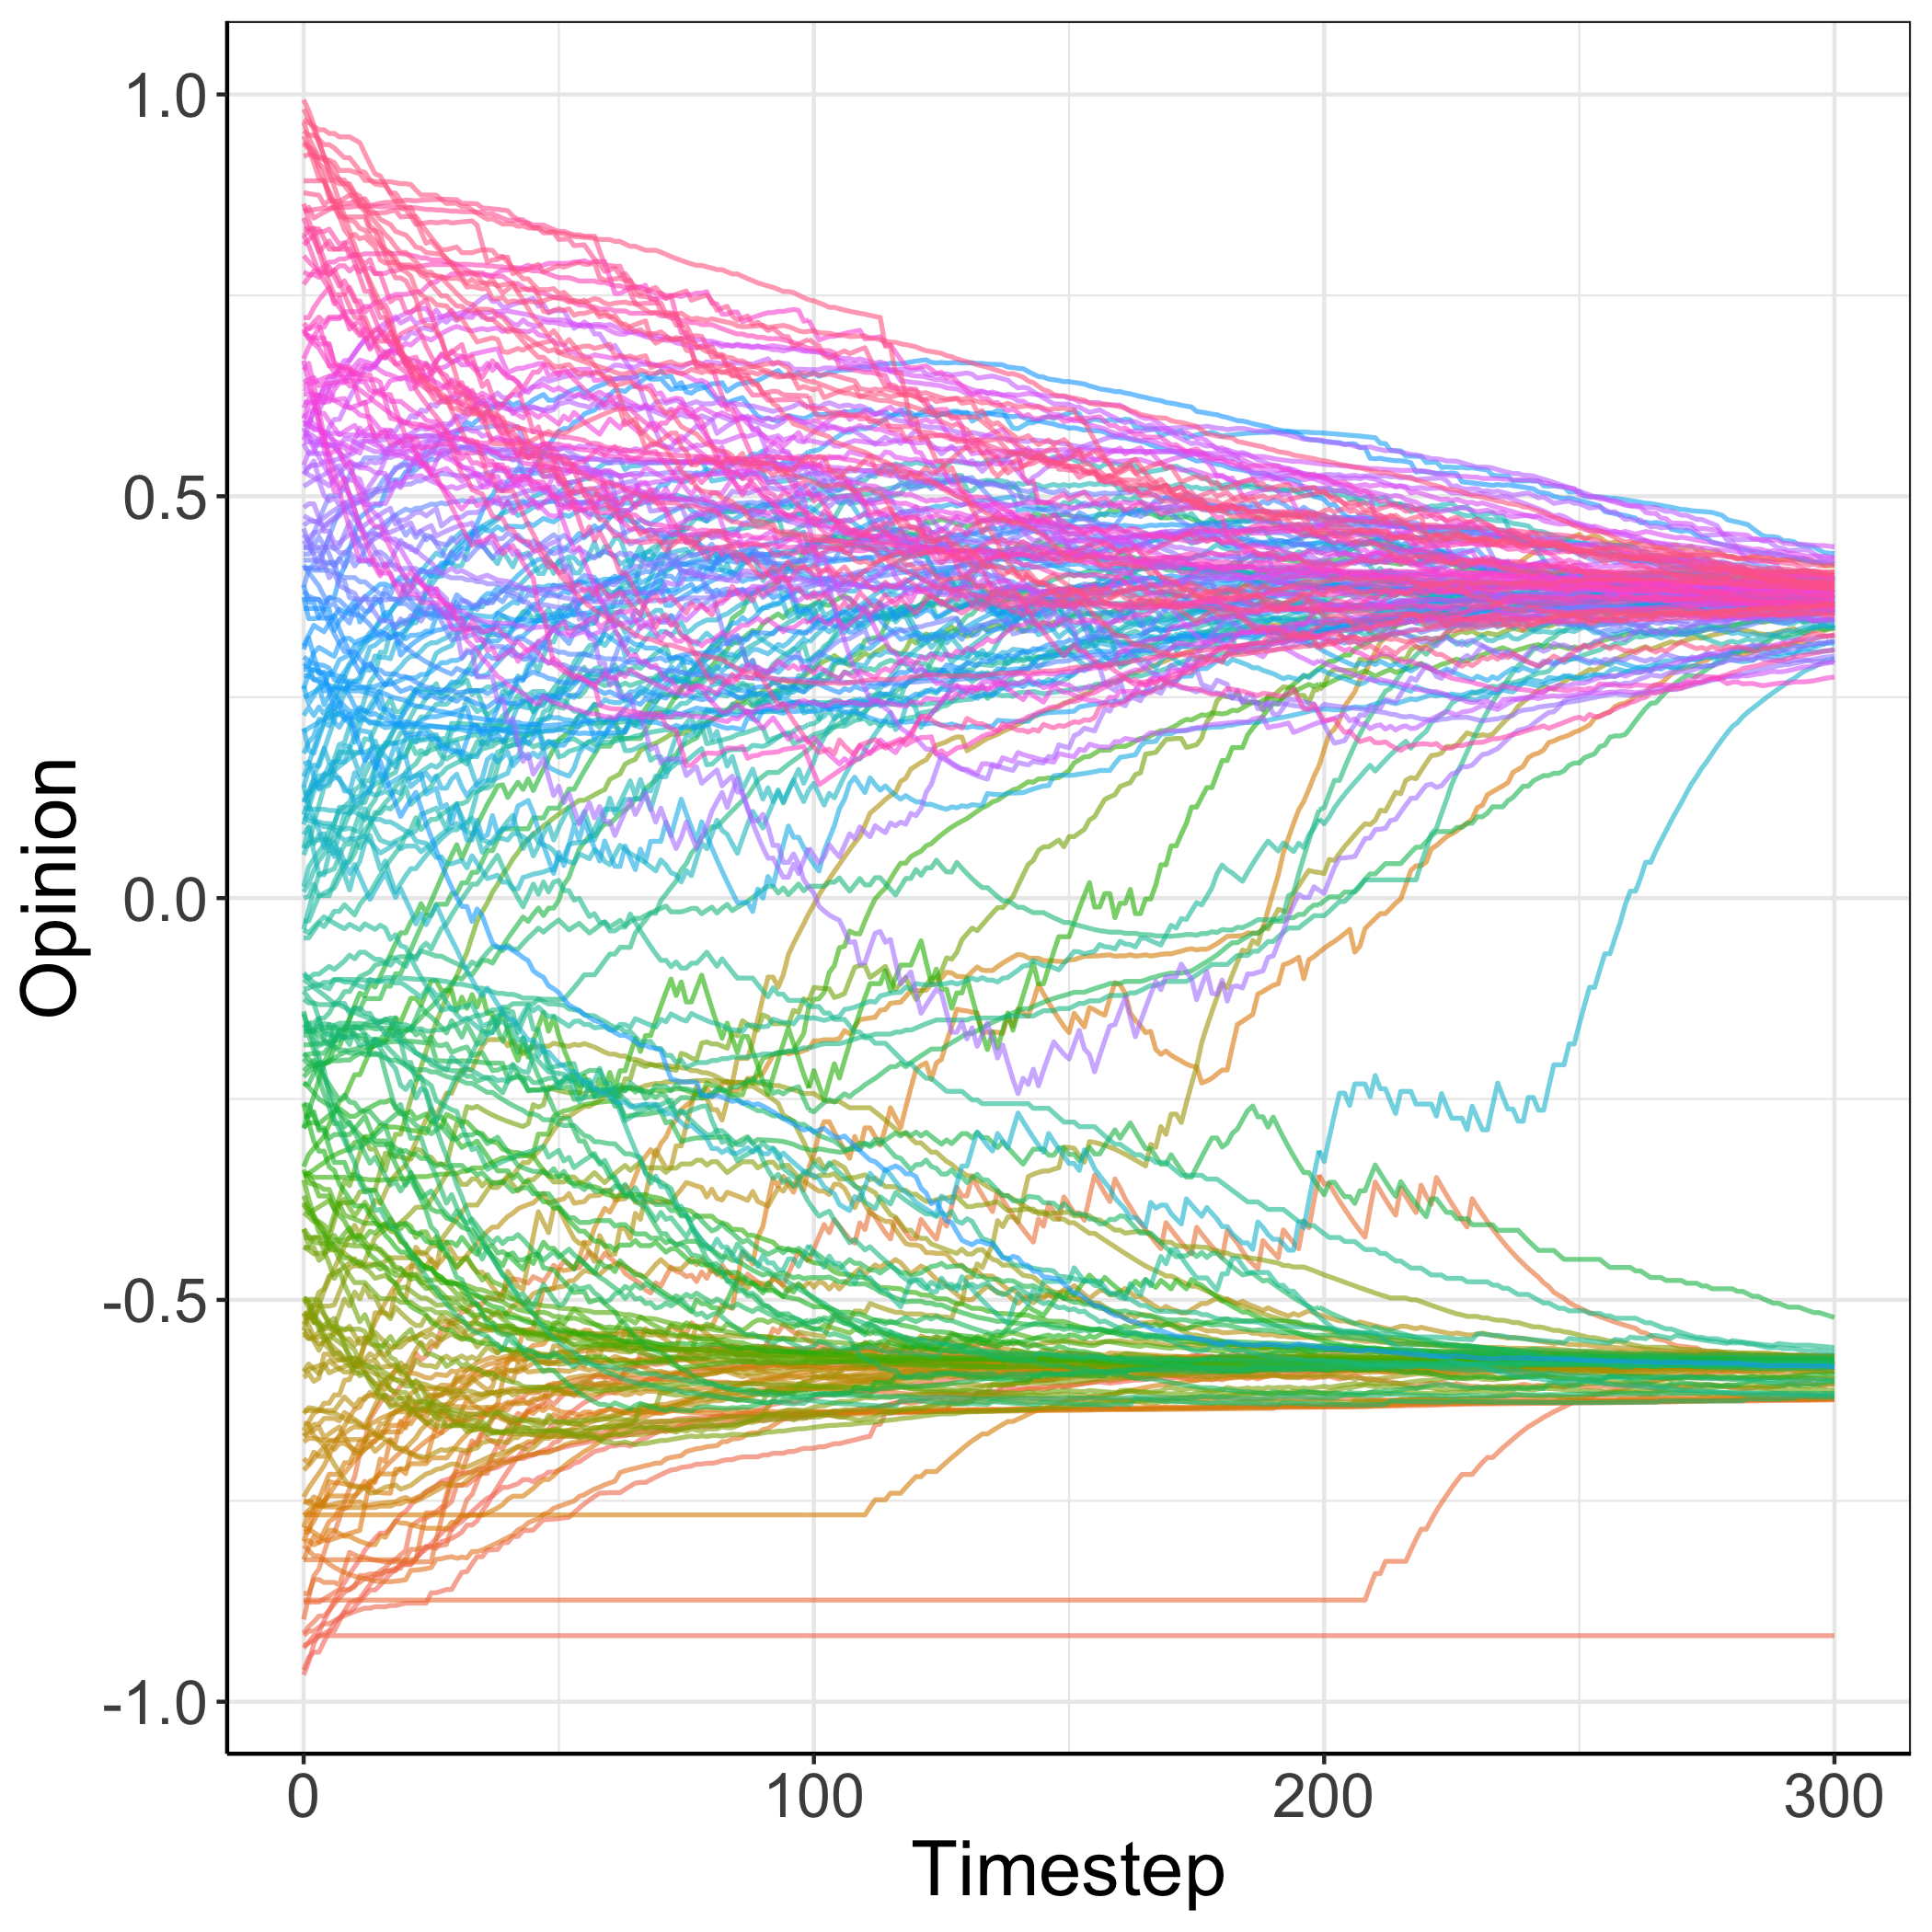

In [40]:
Image("opinion_dynamic_run.png", width=500, height=500)

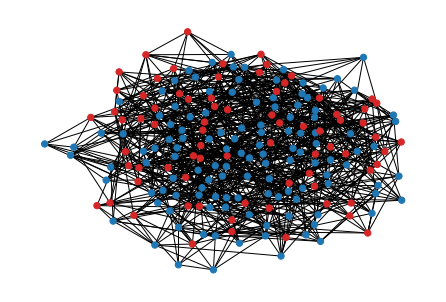

In [57]:
G = model.network.graph
color_dict = {0:'tab:blue', 1:'tab:red'}
colors = [color_dict[c] for c in (model.pop.opinion < 0) ] # Later run clustering instead
nx.draw_spring(G, with_labels=False, node_size=40, node_color=colors)